# Hindi2vec Language Model Pre-training

The goal of this notebook is to train a language model using the [fast.ai](http://www.fast.ai/) version of [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182), with data from [Hindi Wikipedia Dump](https://dumps.wikimedia.org/hiwiki/latest/hiwiki-latest-pages-articles.xml.bz2). 

## EDIT THIS 
# TK
Using 40M/200k/200k tokens of train-validation-test split, we achieved validation perplexity of **27.81627 with 60,004 embeddings at 400 dimensions**, compared to state-of-the-art as of October 27, 2018 at **42.41 for English WikiText-2 by [Yang et al (2018)](https://arxiv.org/abs/1711.03953)**. To the best of our knowledge, there is no comparable research in Thai language at the point of writing (February 17, 2019).

Our workflow is as follows:

* Retrieve and process [Thai Wikipedia Dump](https://dumps.wikimedia.org/thwiki/latest/thwiki-latest-pages-articles.xml.bz2) according to [n-waves/ulmfit-multilingual](https://github.com/n-waves/ulmfit-multilingual)
* Perform 40M/200k/200k tokens of train-validation-test split split
* Minimal text cleaning and tokenization using `newmm` with frozen dictionary (`engine='ulmfit'`) of [pyThaiNLP](https://github.com/pyThaiNLP/pythainlp/)
* Train language model
* Evaluate model based on perplexity and eyeballing
* Extract embeddings to use as "word2vec"

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *    
from fastai.text import * 
from fastai.callbacks import CSVLogger

lang = "hi"

## Text Cleaning

In [2]:
# Download the Wikipedia dump, 
# Uncomment next 2 lines when running for the first time
url = f"https://dumps.wikimedia.org/{lang}wiki/latest/{lang}wiki-latest-pages-articles.xml.bz2"
!wget -c $url

--2019-03-07 16:41:01--  https://dumps.wikimedia.org/hiwiki/latest/hiwiki-latest-pages-articles.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.155.106, 2620:0:861:4:208:80:155:106
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.155.106|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [3]:
# Extract the bz2 file
filename = f"{lang}wiki-latest-pages-articles.xml"
compressed_filename = filename+".bz2"
# Uncomment when running for the first time
!bzip2 -dk $compressed_filename

bzip2: Output file hiwiki-latest-pages-articles.xml already exists.


In [5]:
# Uncomment when running for the first time
# !rm -rvf ulmfit-multilingual/
!git clone https://github.com/n-waves/ulmfit-multilingual

removed 'ulmfit-multilingual/.git/index'
removed 'ulmfit-multilingual/.git/config'
removed directory 'ulmfit-multilingual/.git/branches'
removed 'ulmfit-multilingual/.git/HEAD'
removed 'ulmfit-multilingual/.git/logs/HEAD'
removed 'ulmfit-multilingual/.git/logs/refs/remotes/origin/HEAD'
removed directory 'ulmfit-multilingual/.git/logs/refs/remotes/origin'
removed directory 'ulmfit-multilingual/.git/logs/refs/remotes'
removed 'ulmfit-multilingual/.git/logs/refs/heads/master'
removed directory 'ulmfit-multilingual/.git/logs/refs/heads'
removed directory 'ulmfit-multilingual/.git/logs/refs'
removed directory 'ulmfit-multilingual/.git/logs'
removed 'ulmfit-multilingual/.git/description'
removed directory 'ulmfit-multilingual/.git/refs/tags'
removed 'ulmfit-multilingual/.git/refs/remotes/origin/HEAD'
removed directory 'ulmfit-multilingual/.git/refs/remotes/origin'
removed directory 'ulmfit-multilingual/.git/refs/remotes'
removed 'ulmfit-multilingual/.git/refs/heads/master'
removed directory 

We follow the dataset creation, pre- and post-processing of [n-waves/ulmfit-multilingual](https://github.com/n-waves/ulmfit-multilingual):

* `ulmfit/create_wikitext.py` - Download thwiki in json format and separate them into 40M/200k/200k tokens of train-validation-test split. Articles with least than 100 tokens are removed. Also perform tokenization with whitespaces as separators.
* `ulmfit/postprocess_wikitext.py` - Replace numbers and replace out-of-vocabulary tokens with `xxunk` (frequency of less than 3).

In [6]:
# Uncomment when running for the first time
!git clone https://github.com/attardi/wikiextractor/

fatal: destination path 'wikiextractor' already exists and is not an empty directory.


In [14]:
# !cat wikiextractor/README.md

In [15]:
# Uncomment when running for the first time, this can take a few minutes
# This is run in quiet mode, remove --quiet if you want to see progress status

# !python wikiextractor/WikiExtractor.py $filename -o data/wiki_extr --json --quiet

In [16]:
!ls data/wiki_extr/AA

wiki_00  wiki_12  wiki_24  wiki_36  wiki_48  wiki_60  wiki_72  wiki_84	wiki_96
wiki_01  wiki_13  wiki_25  wiki_37  wiki_49  wiki_61  wiki_73  wiki_85	wiki_97
wiki_02  wiki_14  wiki_26  wiki_38  wiki_50  wiki_62  wiki_74  wiki_86	wiki_98
wiki_03  wiki_15  wiki_27  wiki_39  wiki_51  wiki_63  wiki_75  wiki_87	wiki_99
wiki_04  wiki_16  wiki_28  wiki_40  wiki_52  wiki_64  wiki_76  wiki_88
wiki_05  wiki_17  wiki_29  wiki_41  wiki_53  wiki_65  wiki_77  wiki_89
wiki_06  wiki_18  wiki_30  wiki_42  wiki_54  wiki_66  wiki_78  wiki_90
wiki_07  wiki_19  wiki_31  wiki_43  wiki_55  wiki_67  wiki_79  wiki_91
wiki_08  wiki_20  wiki_32  wiki_44  wiki_56  wiki_68  wiki_80  wiki_92
wiki_09  wiki_21  wiki_33  wiki_45  wiki_57  wiki_69  wiki_81  wiki_93
wiki_10  wiki_22  wiki_34  wiki_46  wiki_58  wiki_70  wiki_82  wiki_94
wiki_11  wiki_23  wiki_35  wiki_47  wiki_59  wiki_71  wiki_83  wiki_95


In [17]:
# !head data/wiki_extr/AA/wiki_00

## Tokenization
### Using StanfordNLP

In [14]:
# !pip install stanfordnlp
import stanfordnlp

In [15]:
print(f"Selected Languages is {lang}. Download models when running for the first time")
# stanfordnlp.download(f"{lang}")

Selected Languages is hi. Download models when running for the first time


### Try out StanfordNLP
Uncomment below to try out StanfordNLP

In [16]:
# config = {
#     'lang': f"{lang}", # Language code for the language to build the Pipeline in
# }
# nlp = stanfordnlp.Pipeline(**config)

In [17]:
# doc = nlp("२०१४ के चुनाव में भारतीय जनता पार्टी, जिसने भ्रस्टाचार और आर्थिक विकास के मुद्दे पर चुनाव लड़ा था, ने अभूतपूर्व बहुमत प्राप्त किया, और नरेंद्र मोदी को प्रधानमन्त्री नियुक्त किया गया।")
# print(*[f'text: {word.text+" "}\tlemma: {word.lemma}\tupos: {word.upos}\txpos: {word.xpos}' for sent in doc.sentences for word in sent.words], sep='\n')

In [20]:
config = {
    'processors': 'tokenize,mwt', # Comma-separated list of processors to use, we load tokenize and mwt only
    'lang': f"{lang}", # Language code for the language to build the Pipeline in
}
nlp = stanfordnlp.Pipeline(**config)
oc = nlp("२०१४ के चुनाव में भारतीय जनता पार्टी, जिसने भ्रस्टाचार और आर्थिक विकास के मुद्दे पर चुनाव लड़ा था, ने अभूतपूर्व बहुमत प्राप्त किया, और नरेंद्र मोदी को प्रधानमन्त्री नियुक्त किया गया।")
# print(*[f'text: {word.text+" "}\tlemma: {word.lemma}\tupos: {word.upos}\txpos: {word.xpos}' for sent in doc.sentences for word in sent.words], sep='\n')

Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': '/home/jupyter/stanfordnlp_resources/hi_hdtb_models/hi_hdtb_tokenizer.pt', 'lang': 'hi', 'shorthand': 'hi_hdtb', 'mode': 'predict'}
Done loading processors!
---


In [21]:
doc = nlp("२०१४ के चुनाव में भारतीय जनता पार्टी, जिसने भ्रस्टाचार और आर्थिक विकास के मुद्दे पर चुनाव लड़ा था, ने अभूतपूर्व बहुमत प्राप्त किया, और नरेंद्र मोदी को प्रधानमन्त्री नियुक्त किया गया।")

In [22]:
tokens = [word.text for sent in doc.sentences for word in sent.words]

In [23]:
tokens

['२०१४',
 'के',
 'चुनाव',
 'में',
 'भारतीय',
 'जनता',
 'पार्टी',
 ',',
 'जिसने',
 'भ्रस्टाचार',
 'और',
 'आर्थिक',
 'विकास',
 'के',
 'मुद्दे',
 'पर',
 'चुनाव',
 'लड़ा',
 'था',
 ',',
 'ने',
 'अभूतपूर्व',
 'बहुमत',
 'प्राप्त',
 'किया',
 ',',
 'और',
 'नरेंद्र',
 'मोदी',
 'को',
 'प्रधानमन्त्री',
 'नियुक्त',
 'किया',
 'गया',
 '।']

In [ ]:
# !rm -rv data/wiki/ # remove previous old Moses Tokens

In [25]:
# !cp ulmfit-multilingual/ulmfit/create_wikitext.py create_wikitext_stanfordnlp.py

In [27]:
# !python create_wikitext_stanfordnlp.py -i data/wiki_extr/ -o data/wiki/ -l hi

Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': '/home/jupyter/stanfordnlp_resources/hi_hdtb_models/hi_hdtb_tokenizer.pt', 'lang': 'hi', 'shorthand': 'hi_hdtb', 'mode': 'predict'}
Done loading processors!
---
Writing to data/wiki/hi-2/hi.wiki.train.tokens...
data/wiki/hi-2/hi.wiki.train.tokens. # documents: 13,210. # tokens: 2,002,437.
Copying data/wiki/hi-2/hi.wiki.train.tokens to data/wiki/hi-100/hi.wiki.train.tokens & data/wiki/hi-all/hi.wiki.train.tokens.
Writing to data/wiki/hi-2/hi.wiki.valid.tokens...
data/wiki/hi-2/hi.wiki.valid.tokens. # documents: 1,724. # tokens: 200,137.
Copying data/wiki/hi-2/hi.wiki.valid.tokens to data/wiki/hi-100/hi.wiki.valid.tokens & data/wiki/hi-all/hi.wiki.valid.tokens.
Writing to data/wiki/hi-2/hi.wiki.test.tokens...
data/wiki/hi-2/hi.wiki.test.tokens. # documents: 203. # tokens: 200,062.
Copying data/wiki/hi-2/hi.wiki.test.tokens to data/wiki/hi-100/hi.wiki.test.tokens & data/wiki/hi-all/hi.wiki.test.tokens.
Writing to data/wi

In [28]:
!wc -l data/wiki/hi-2/hi.wiki.train.tokens

34336 data/wiki/hi-2/hi.wiki.train.tokens


In [29]:
!head data/wiki/hi-2/hi.wiki.train.tokens

=मालिश=
मालिश
शरीर की बाहरी एवं नीचे स्थित मांशपेशियों एवं संयोजी उत्तकों को दबाना , हिला-डुलाना आदि मालिश ( Massage ) कहलाता है । इससे उनकी कार्य करने की क्षमतबढ़ती है और उनकी टूट-फूट का निवारन होता है । इससे आराम मिलता है और शरीर स्वस्थ रहता है ।
मालिश मांसपेशियों और संयोजी ऊतक के सतही और गहरी परतों में हेरफेर समारोह बढ़ाने उपचार प्रक्रिया में सहायता और छूट और अच्छी तरह से किया जा रहा है को बढ़ावा देने के है। शब्द फ्रेंच मालिश सानना के घर्षण से आता है , या " स्पर्श महसूस , या संभाल " या लैटिन Massa से " बड़े पैमाने पर , आटा " अर्थ अरबी Massa अर्थ से cf . यूनानी क्रिया μάσσω ( massō ) " संभाल करने के लिए , स्पर्श , हाथों से काम करने के लिए आटा गूंध. भेद anatripsis मालिश के लिए प्राचीन ग्रीक शब्द था और लैटिन frictio था ।
मालिश पर अभिनय और दबाव के साथ शरीर से छेड़छाड़ शामिल है - संरचित , असंरचित , स्थिर , या चलती - तनाव , गति , या कंपन किया मैन्युअल रूप से या यांत्रिक एड्स के साथ. टारगेट ऊतकों मांसपेशियों , tendons , ligaments , प्रावरणी , त्वचा , जोड़ों , या अन्य संयोजी ऊतक , के रूप मे

In [30]:
data_path = f"data/wiki/{lang}-2/"
model_path = f"models/wiki/{lang}-2"
assert Path(data_path).exists()

In [31]:
def istitle(line):
    return len(re.findall(r'^ ?=\|[^=]*\|= ?$', line)) != 0

import gc
def read_wiki_articles(filename):
    articles = []
    with open(filename, encoding='utf8') as f:
        lines = f.readlines()
    current_article = []
    for i,line in enumerate(lines):
        current_article.append(line)
        if i < len(lines)-2 and lines[i+1].strip() == "" and istitle(lines[i+2]):
            articles.append("".join(current_article))
            current_article = []
        articles.append("".join(current_article))
        gc.collect()
#     print(current_article[:10])
    gc.collect()
    print(f"Wiki text was split to {len(articles)} articles")
    return pd.DataFrame({'texts': np.array(articles, dtype=np.object)})

In [32]:
trial_filename = f"{data_path}{lang}.wiki.valid.tokens"
print(trial_filename)
with Path(trial_filename).open("r") as f:
    content = f.readlines()[:5]
    current_article = []
    for line in content:
        current_article.append(line)
    print("".join(current_article))
        

data/wiki/hi-2/hi.wiki.valid.tokens
=श चिंग=
श चिंग
श चिंग चीन का पहला काव्य ग्रंथ है जो ईसा पूर्व सातवीं सदी में रचा गया । ' श चिंह ' का अर्थ ह - ' सर्वश्रेष्ठ प्राचीन कविताओं का संग्रह ' । इस ग्रंथ में व्यंग्यात्मक कविता , प्रेम के गीत , वीर गाथा , श्रम के गीत तथा पूजा के गीत इत्यादि शामिल हैं । इस ग्रंथ का जन्म प्राचीन यूनानी होमर के महाकाव्य से भी कई सौ वर्ष से पहले हुआ था ।
इस कविता ग्रंथ में ईसा पूर्व 11वीं शताब्दी से ले कर सातवीं शताब्दी तक के पांच सौ सालों की 305 कविताएं संगृहित हैं जो ग्रंथ तीन भागों में बंटे हुए हैं । इस के पहले भाग में उस जमाने के 15 राज्यों में प्रचलित 160 लोकगीत हैं , दूसरे भाग में पश्चिमी चो राजवंश के दरबारी अनुष्ठानों और कुलीन वर्ग की रस्म सभाओं में प्रयुक्त 105 गीतिकाव्य हैं , जबकि तीसरे भाग में श्रद्धा व पूजा से जुड़ी 40 कविताएं हैं जो मुख्य तौर पर पूर्वजों व देवताओं की महानता का गुणगान करती हैं ।
=महाद्वीपीय विस्थापन=



In [ ]:
# valid_df = read_wiki_articles(f'{data_path}{lang}.wiki.valid.tokens').iloc[:-1,:]
# test_df = read_wiki_articles(f'{data_path}{lang}.wiki.test.tokens').iloc[:-1,:]
# train_df.shape, valid_df.shape, test_df.shape

In [30]:
# #join tokens together, I think this is unique to Thai tokenization
# train_df['texts'] = train_df.texts.map(lambda x: ''.join(x.split('|')))
# valid_df['texts'] = valid_df.texts.map(lambda x: ''.join(x.split('|')))
# test_df['texts'] = test_df.texts.map(lambda x: ''.join(x.split('|')))

# Fucking Nightmare

In [56]:
# !mkdir -p "/home/jupyter/hindi2vec/data/valid/"
# !cp data/wiki/hi-2/hi.wiki.valid.tokens /home/jupyter/hindi2vec/data/valid/hi.wiki.valid.tokens

In [57]:
# !mkdir -p "/home/jupyter/hindi2vec/data/train/"
# !cp data/wiki/hi-2/hi.wiki.train.tokens /home/jupyter/hindi2vec/data/train/hi.wiki.train.tokens

In [ ]:
# train_df['texts']

## Data Preparation

We used the `newmm` engine of `pyThaiNLP` to perform tokenization. Out of randomnum tokens from all of training set, we chose 60,000 embeddings (plus two for unknown and padding) of tokens which appeared more than twice (not typos) in the training set.


We perform the following text processing:

* Fix html tags to plain texts
* Lowercase all English words and if a word is written in all caps, we put it in a lower case and add `xxup` before
* Repetitive characters: Thai usually emphasizes adjectives by repeating the last character such as `อร่อยมากกกกกกก` to `อร่อยมาก xxrep 7 ` so that the word still retains its original form. 
* Normalize character order: for instance `นำ้` to `น้ำ`
* Add spaces around / and #
* Remove multiple spaces and newlines
* Remove empty brackets of all types (`([{`) which might result from cleaning up
* `pyThaiNLP`'s `newmm` word tokenizer with frozen dictionary (`engine ='ulmfit'`)  is used to tokenize the texts.

### Hindi Tokenizer

We use the `newmm` tokenizer with a dictionary frozen as of 2018-10-23.

In [45]:
# text='วิทยาศาสตร์ดาวเคราะห์เป็นสาขาวิชาที่ศึกษาเกี่ยวกับองค์ประกอบของดาวเคราะห์'
# a = word_tokenizeimport stanfordnlp
class HindiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.config = {
            'processors': 'tokenize,mwt', # Comma-separated list of processors to use, we load tokenize and mwt only
            'lang': f"{self.lang}", # Language code for the language to build the Pipeline in
        }
        self.nlp = stanfordnlp.Pipeline(**config)
    
    def setup(self, lang:str):
        stanfordnlp.download(f"{lang}")
        
    def tokenizer(self, t:str) -> List[str]:
        doc = self.nlp(t)
        return [word.text for sent in doc.sentences for word in sent.words]

In [130]:
def word_tokenize(text, lang="hi"):
    config = {
            'processors': 'tokenize,mwt', # Comma-separated list of processors to use, we load tokenize and mwt only
            'lang': f"{lang}", # Language code for the language to build the Pipeline in
    }
    nlp = stanfordnlp.Pipeline(**config)
    doc = nlp(text)
    return [word.text for sent in doc.sentences for word in sent.words]

In [46]:
tokenizer = Tokenizer(tok_func=HindiTokenizer, lang='hi')

In [47]:
tokenizer.special_cases

['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep']

In [4]:
# #integrated into pythainlp.ulmfit.utils
from fastai.text.transform import *
# from pythainlp.tokenize import word_tokenize
# from pythainlp.util import normalize as normalize_char_order

# class ThaiTokenizer(BaseTokenizer):
#     "Wrapper around a newmm tokenizer to make it a `BaseTokenizer`."
#     def __init__(self, lang = 'th'):
#         self.lang = lang
#     def tokenizer(self, t):
#         return word_tokenize(t,engine='ulmfit')
#     def add_special_cases(self, toks):
#         pass
    
def replace_rep_after(t):
    "Replace repetitions at the character level in `t` after the repetition"
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c} {TK_REP} {len(cc)+1} '
    re_rep = re.compile(r'(\S)(\1{3,})')
    return re_rep.sub(_replace_rep, t)

def rm_useless_newlines(t):
    "Remove multiple newlines in `t`."
    return re.sub('[\n]{2,}', ' ', t)

def rm_brackets(t):
    "Remove all empty brackets from `t`."
    new_line = re.sub('\(\)','',t)
    new_line = re.sub('\{\}','',new_line)
    new_line = re.sub('\[\]','',new_line)
    return(new_line)

#in case we want to add more specific rules for thai
pre_rules_th = [fix_html, replace_rep_after, normalize_char_order, 
                spec_add_spaces, rm_useless_spaces, rm_useless_newlines, rm_brackets]
post_rules_th = [replace_all_caps, deal_caps]

### Data Bunch

We trained the language model based on 40M/200k/200k tokens of train-validation-test split from [Thai Wikipedia Dump](https://dumps.wikimedia.org/thwiki/latest/thwiki-latest-pages-articles.xml.bz2). Tokens are generated and numericalized filtering all words with frequency more than 3 and at maximum vocab size of 60,000 (plus unknown and padding tokens).

In [48]:
tt = Tokenizer(tok_func = HindiTokenizer, lang = f"{lang}")

In [51]:
tt.special_cases

['xxunk', 'xxpad', 'xxbos', 'xxfld', 'xxmaj', 'xxup', 'xxrep', 'xxwrep']

In [63]:
model_path

'models/wiki/hi-2'

In [158]:
# ?TextLMDataBunch.from_folder

In [159]:
textlm = TextLMDataBunch.from_folder(path="/home/jupyter/hindi2vec/data/", max_vocab=100000, min_freq=3)

In [160]:
textlm.show_batch()

idx,text
0,"प्रक्रिया में सहायता और छूट और अच्छी तरह से किया जा रहा है को बढ़ावा देने के है । शब्द फ्रेंच मालिश सानना के घर्षण से आता है , या "" स्पर्श महसूस , या संभाल "" या लैटिन xxmaj xxunk से "" बड़े पैमाने पर , आटा "" अर्थ अरबी xxmaj xxunk अर्थ से cf . यूनानी क्रिया xxunk ( xxunk ) "" संभाल करने के लिए , स्पर्श"
1,रहे पांचवीं भारतीय से जुड़ा उनका 11वां ब्रिगेड लौट आया था । उनका पांचवां ब्रिगेड जून 1942 में लौट आया और xxunk xxunk में युद्ध किया । मई से जून 1942 तक xxunk की लड़ाई में भाग लेने के समय सीरिया से दसवां भारतीय इन्फैन्ट्री डिवीजन पहुँच गया उसके बाद एल अलामीन की पहली लड़ाई में 72 घंटे तक एक्सिस सेना को रोके रखा जिससे आठवीं सेना को सुरक्षित ढंग
2,"जाता है ( जैसे किसी दर्शक को दिखाया जाने वाला ऋण राहत से संबंधित कोई विज्ञापन जिसे मेल में देर से नोटिस प्राप्त हुआ हो ) या उसे बुनियादी सन्देश से परे कोई मनोरंजन प्राप्त होता है ( जैसे xxunk के "" xxunk द बीफ ? "" अभियान के लिए क्लासिक xxunk कार्यक्रम ) तो दर्शक उस विज्ञापन का इंतजार कर सकते हैं और शायद उसे फिर से देखने की"
3,"। क्या हम हाथ में है उनके प्रशंसकों द्वारा कलाकारों के ज्यादातर xxunk हैं । वैज्ञानिक मूल्यांकन और सौंदर्य व्याख्याओं दुर्लभ हैं । कला आलोचना एक xxunk में इसलिए है । इस स्थिति विश्वविद्यालय को बदलने के लिए प्रदर्शन कला के क्षेत्र में अनुसंधान और उच्च शिक्षा के लिए एक मजबूत नींव रखने पर ध्यान देना होगा । सांस्कृतिक अध्ययन , सांस्कृतिक पत्रकारिता , मल्टीमीडिया , मास कम्युनिकेशन , महिला"
4,"xxunk के कारण सार्वजनिक करने का आरोप xxunk पर लगाया । इस को अदालत के बाहर समझौता किया गया और रूनी ने उनसे माफी भी माँगा । xxunk सीज़न मे दोनो फिर से साथ हो गए । \n = हेनरी xxunk \n हेनरी फोंडा \n हेनरी xxunk फोंडा ( मई १६ , xxunk १२ , १९८२ ) एक अमेरिकी और रंगमंच अभिनेता थे । उन्होने ब्रॉडवे अभिनेता"


In [161]:
textlm.sanity_check()

In [72]:
data = (ItemLists(model_path,
                  TextList.from_folder(path="data/").no_split()
#     TextList.from_df(train_df, model_path, cols=['texts'], processor=processor),
#     TextList.from_df(valid_df, model_path, cols=['texts'], processor=processor))
    .label_for_lm()
#     .add_test(TextList.from_df(test_df, model_path, cols=['texts'], processor=processor))
    .databunch(bs=32)))

TypeError: __init__() missing 1 required positional argument: 'valid'

In [162]:
data = textlm

In [106]:
?textlm

In [163]:
%time
filename = f"{lang}_wiki_lm_data.pkl"
data.save()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs


In [164]:
%time
data = load_data("/home/jupyter/hindi2vec/data")
data.sanity_check()
len(data.train_ds), len(data.valid_ds), len(data.test_ds)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


TypeError: object of type 'NoneType' has no len()

In [165]:
data.show_batch(5)

idx,text
0,", हाथों से काम करने के लिए आटा xxunk भेद xxunk मालिश के लिए प्राचीन ग्रीक शब्द था और लैटिन xxunk था । \n मालिश पर अभिनय और दबाव के साथ शरीर से छेड़छाड़ शामिल है - संरचित , xxunk , स्थिर , या चलती - तनाव , गति , या कंपन किया मैन्युअल रूप से या यांत्रिक एड्स के साथ. टारगेट ऊतकों मांसपेशियों , xxunk , xxunk ,"
1,"से पीछे हटने का मौका मिला . \n एल अलामीन की दूसरी लड़ाई के लिए xxunk चौथा डिवीजन लौट आया और उसने आठवीं सेना की पंक्ति के केन्द्र में xxunk रिज पर कब्ज़ा किया और सीमा के केन्द्र की तरफ ध्यान xxunk के इरादे से एक नकली और दो छोटे हमले किए . \n ऑपरेशन xxunk ( चौथा भारतीय , दूसरा न्यूजीलैंड और xxunk xxunk डिवीजन ) xxunk"
2,भी इच्छा रख सकते हैं । \n 2 जनवरी 1971 से अमेरिकी टीवी होने वाले सिगरेट के विज्ञापनों पर प्रतिबन्ध लगा दिया गया । शराब उत्पादों के विज्ञापन की अनुमति है लेकिन टीवी विज्ञापन में किसी भी शराब उत्पाद के सेवन की अनुमति नहीं है । 1990 के दशक के अंतिम दौर से टीवी विज्ञापन ने अधिक विविध रूप धारण कर लिया है और xxunk घरेलू उत्पाद और खाद्य
3,"अध्ययन में यह नई पीढ़ी के पाठ्यक्रमों के लिए , आदि प्रलेखन एक बहुत फार्म ऐसे पाठ्यक्रमों को फायदा होगा । \n विश्वविद्यालय के आदर्श वाक्य के नए युग की आत्मज्ञान की भावना जागृत पारंपरिक तरीके में कला शिक्षा के लिए एक मजबूत प्रणाली डिजाइन करने के xxunk आदर्श वाक्य के नए युग की आत्मज्ञान की भावना जागृत पारंपरिक तरीके में कला शिक्षा के लिए एक मजबूत प्रणाली डिजाइन"
4,"खूब नाम कमाया । १९३५ में उन्होने अपने हॉलीवुड करियर की शुरुआत की थी और अकादमी पुरस्कार के लिए नामांकित हुए , टॉम xxunk का पात्र ' ग्रेप्स ऑफ xxunk ' में निभाने के लिए । इस फिल्म के कारण उनके फिल्म करियर ने रफ्तार पकड़ ली और उसके बाद छह दशकों तक वे फिल्मो में काम करते रहे । उन्होने कई क्लासिक फिल्मो में काम किया , जैसे '"


In [166]:
next(iter(data.train_dl))

[tensor([[   12,  1510,    12,  ...,     8,    42,    11],
         [   19,  2820,    33,  ...,     0,    69,     9],
         [  333,    51,   659,  ...,   373,   120,    10],
         ...,
         [   13,   120,     9,  ...,    17,   409,  4186],
         [ 1278,  8186,  5298,  ...,   195,  7691,    14],
         [   31,  3492,    18,  ...,    12, 10915,    12]], device='cuda:0'),
 tensor([[ 1510,    12,  4324,  ...,    42,    11,   194],
         [ 2820,    33,     9,  ...,    69,     9,    15],
         [   51,   659,   111,  ...,   120,    10,   332],
         ...,
         [  120,     9,   738,  ...,   409,  4186, 18890],
         [ 8186,  5298,    34,  ...,  7691,    14,    66],
         [ 3492,    18,  2805,  ..., 10915,    12,  4161]], device='cuda:0')]

In [167]:
pickle.dump(data.vocab.itos, open(f'{model_path}/{lang}_wiki_itos.pkl','wb'))

### Vocab

In [127]:
vocab_lm = data.vocab
# vocab_lm.numericalize(word_tokenize('สวัสดีครับพี่น้อง', engine='ulmfit'))

In [168]:
vocab_lm.numericalize(word_tokenize("से अमेरिकी टीवी होने वाले सिगरेट के विज्ञापनों पर प्रतिबन्ध लगा दिया गया", lang=lang))

Use device: gpu
---
Loading: tokenize
With settings: 
{'model_path': '/home/jupyter/stanfordnlp_resources/hi_hdtb_models/hi_hdtb_tokenizer.pt', 'lang': 'hi', 'shorthand': 'hi_hdtb', 'mode': 'predict'}
Done loading processors!
---


[16, 336, 756, 93, 88, 6619, 8, 1248, 21, 3999, 326, 64, 38]

In [169]:
vocab_lm.textify([6619, 8, 1248, 21, 3999])

'सिगरेट के विज्ञापनों पर प्रतिबन्ध'

## Language Modeling

We train the language model according to the [ULMFit paper](https://arxiv.org/abs/1801.06146). We use the name hyperparameters as [n-waves/ulmfit-multilingual](https://github.com/n-waves/ulmfit-multilingual).

In [170]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

In [171]:
learn = language_model_learner(data, AWD_LSTM, config=config, pretrained=False, **trn_args)

In [172]:
learn.opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn.callback_fns += [partial(CSVLogger, filename="logs")]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


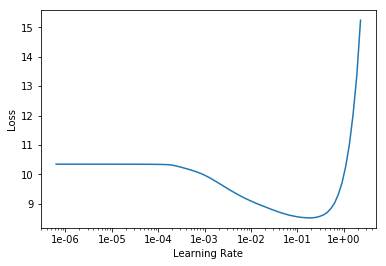

In [173]:
learn.lr_find()
learn.recorder.plot()

In [174]:
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,6.860805,6.651607,0.075194,04:09


In [175]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,6.199951,6.228636,0.133992,05:17
2,5.651200,5.698413,0.191571,05:30
3,5.224508,5.287286,0.227300,05:30
4,4.897160,5.019299,0.248006,05:30
5,4.666602,4.864602,0.259487,05:31
6,4.482499,4.769929,0.266421,05:31
7,4.334930,4.724351,0.268507,05:31
8,4.223247,4.694628,0.270599,05:31
9,4.157586,4.681571,0.271860,05:31
10,4.182777,4.671778,0.272656,05:31


In [176]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,4.256379,4.698619,0.269978,05:20
2,4.055941,4.658815,0.272787,05:32


In [177]:
learn.fit_one_cycle(2, (1e-3)/2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,4.038492,4.683591,0.271404,05:19
2,3.935008,4.667615,0.271361,05:31


In [140]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3/3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,4.295037,4.828024,0.263757,06:01
2,4.284737,4.840027,0.262369,06:02
3,4.240898,4.836672,0.262301,06:01
4,4.175188,4.839178,0.262597,06:01
5,4.086222,4.844824,0.261966,06:01
6,4.006917,4.866828,0.260113,06:01
7,3.941406,4.879977,0.259851,06:01
8,3.888287,4.888649,0.259220,06:01
9,3.876373,4.894383,0.259472,06:02
10,3.960637,4.877632,0.259259,06:02


In [141]:
learn.save(f'{lang}_wiki_lm')
learn.save_encoder(f'{lang}_wiki_enc')

### Eyeballing Test
We perform eyeballing test by having the model "fill in the blanks".

In [143]:
# from utils import *
from fastai import *    
from fastai.text import * 
from fastai.callbacks import CSVLogger
# data_path = f'{lang}-all-unk/'
# model_path = f'{lang}wiki_data/'

#data
data = load_data("/home/jupyter/hindi2vec/data")
data.sanity_check()

#lm
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data, AWD_LSTM, config=config, pretrained=False, **trn_args)
learn.opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

#load weights
lang = "hi"
learn.load(f'{lang}_wiki_lm');

In [156]:
learn.predict(' इंडोनेशिया में आयी एक सूनामी ',10, sep=' ')

' इंडोनेशिया में आयी एक सूनामी  योजना पर एंग्री 1672 में उद्घाटन कर दिया । रेल'

In [154]:
??learn.predict

## Embeddings

We extract the embedding layer of the encoder to be used in the same manner as `word2vec`. We can also create sentence vector by summing or averaging the vectors. For more details about `word2vec` use cases, see`word2vec_examples.ipynb`. Note that we use word vectors from `v0.1` since it was trained specifically for the purpose and has comparable dimensions to `fastText` embeddings.

### Extract

In [148]:
#how we extracted the embeddings
emb_weights = list(learn.model.named_parameters())[0][1]
emb_np = to_np(emb_weights.data)
emb_np.shape

(45238, 400)

In [33]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(f'{model_path}models/thai2vec.vec',binary=False,
                                         unicode_errors = 'ignore')

In [35]:
model.save_word2vec_format(f'{model_path}models/thai2vec.vec',f'{model_path}models/thai2vec.vocab',False)
model.save_word2vec_format(f'{model_path}models/thai2vec.bin',None,True)

## Document Vectors

We can also get document vector from the language model by applying the encoder to a sentence.

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tt = ThaiTokenizer()
def document_vector(ss, learn, data):
    s = tt.tokenizer(ss)
    t = torch.tensor(data.vocab.numericalize(s), requires_grad=False).to(device)
    m = learn.model[0].encoder.to(device)
    res = m(t).mean(0).cpu().detach().numpy()
    return(res)

In [93]:
ss = 'วันนี้วันดีปีใหม่'
document_vector(ss,learn,data)

array([ 0.066298,  0.307813,  0.246051,  0.008683, ..., -0.058363,  0.133258, -0.289954, -1.770246], dtype=float32)

In [4]:
from pythainlp.ulmfit import *
document_vector('วันนี้วันดีปีใหม่',learn,data)

array([ 0.066298,  0.307813,  0.246051,  0.008683, ..., -0.058363,  0.133258, -0.289954, -1.770246], dtype=float32)